## Semi-Supervised GANの構造
- 原理：GANでデータ分布への理解を利用して、少ないlabeled training dataだけど高い正確率分類器を得られる。
 - **internalizing hidden structures** in the data, semi-supervised learning strives to **generalize** from the **small subset of labeled** data points to effectively classify new, previously unseen examples.
 - The Generator serves as a source of additional information that **helps the Discriminator learn the relevant patterns** in the data.
- semi-supervised learningは人の学習方法に近い。
- 普段はGeneratorを重要視するが、ここでDiscriminatorを関心している。
- labeled dataは良くtraining dataの1~2%しかない。
- supervised部分：
 - Labeled data (x,y)はclass 1~nにトレーニング。（multiclass,例えばsoftmax）
- unsupervised部分：
 - 他の部分は以前のGANと同じ。Unlabeled data xやGeneratorが作ったdata x* はtrue/fakeにトレーニング。（binary,例えばsigmoid）

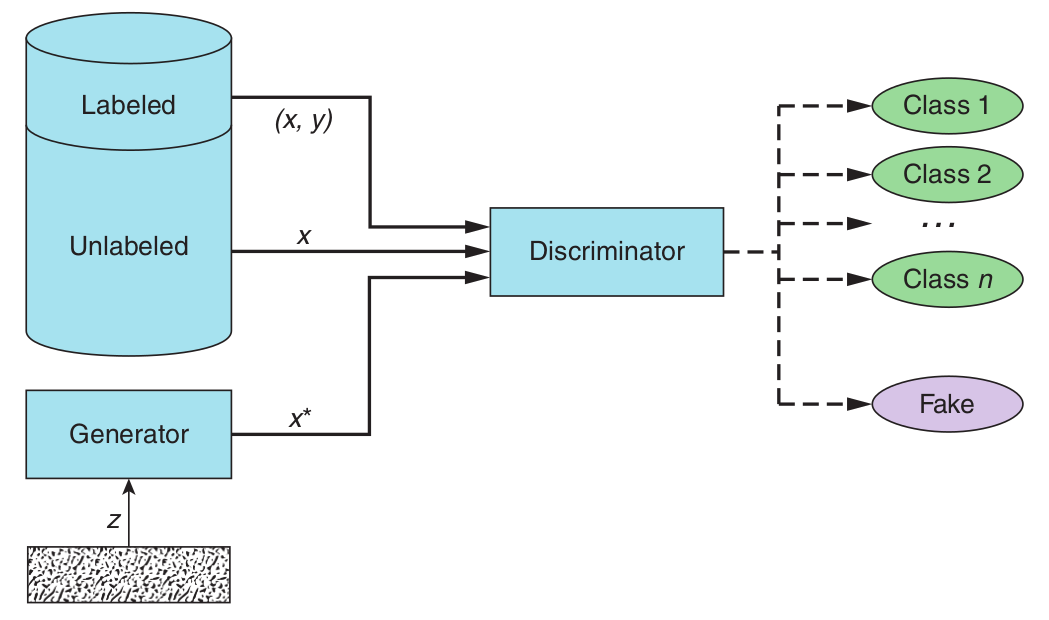

In [3]:
from IPython.display import Image
Image("img/semi-supervised-gan-2020-02-25 20-31-50.png")

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K
from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense, Dropout, 
                          Flatten, Input, Lambda, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
# one-hot encoding
from keras.utils import to_categorical

## Step 1: Dataset producer

In [34]:
class Dataset:
    def __init__(self, num_labeled):
        # labeled training dataの数
        self.num_labeled = num_labeled
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        
        def preprocess_imgs(x):
            x = (x.astype(np.float32) - 127.5) / 127.5
            x = np.expand_dims(x, axis=3)
            return x
        
        def preprocess_labels(y):
            # -1の意味はこのdimensionのサイズが分からない。1列にしてaxis=0のサイズは自動的に決める。
            return y.reshape(-1, 1)
        
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)
        
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)
        
    def batch_labeled(self, batch_size):
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels
    
    def batch_unlabeled(self, batch_size):
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs
    
    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train
    
    def test_set(self):
        return self.x_test, self.y_test
    
    def training_set_num(self, number_of_samples):
        x_train = self.x_train[range(number_of_samples)]
        y_train = self.y_train[range(number_of_samples)]
        return x_train, y_train

In [35]:
# 100個labeled training dataを使う
num_labeled = 100
dataset = Dataset(num_labeled)

In [4]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100
num_classes = 10

## Step 2: Generator
- DCGANと変わらない

In [5]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')) # 14*14*128
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same')) # 14*14*64
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')) # 28*28*1
    model.add(Activation('tanh'))
    return model

## Step 3: Discriminator
- 最後のActivationが違って、その前のネットワークは一緒。
- 最後のActivationは、supervised multiclass用だったら、softmax。unsupervised binary用だったら、sigmoid.
- Dropoutを使う理由：Generalizationが良くなるように。
 - We add dropout because of the increased complexity of the SGAN classification task and to improve the model's ability to **generalize from only 100 labeled examples**.

In [10]:
def build_discriminator_net(img_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same')) # 14*14*32
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same')) # 7*7*64
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same')) # 3*3*128
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Flatten())
    # Full connected layer with num_classes neurons
    model.add(Dense(num_classes))
    return model

In [11]:
def build_discriminator_supervised(discriminator_net):
    # 直接にdiscriminator_netの後ろにaddしてもいいでしょう。多分modelを新規する理由は、discriminatorを変更したくないから。
    model = Sequential()
    model.add(discriminator_net)
    model.add(Activation('softmax'))
    return model

- $sigmoid=\frac{1}{1+e^{-x}}=\frac{e^x}{e^x+1}=1-\frac{1}{1+e^x}$.
- 下記実装はActivation('sigmoid')を使ってない。理由は10 * 1のvectorではなく、scalarが欲しいからです。
 - Actiとpredictの差はK.sumだ。Activation('sigmoid')の結果はnum_classes * 1です。predictの結果はscalarです。

In [12]:
def build_discriminator_unsupervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)
    # sigmoid function
    def predict(x):
        prediction = 1.0 - (1.0 /
                           (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction
    
    model.add(Lambda(predict))
    return model

## Step 4: GAN

In [13]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

## Step 5: Supervised & Unsupervised Discriminatorのcompile

In [15]:
# Core Discriminator network: These layers are shared during supervised and unsupervised training
discriminator_net = build_discriminator_net(img_shape)

discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                metrics=['accuracy'],
                                optimizer=Adam())

discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
# unsupervised discriminatorでmetricsを使ってなく、これはただ後ほどのplotで使わないからだけ。
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                  optimizer=Adam())

## Step 6: GANのcompile

In [16]:
generator = build_generator(z_dim)
discriminator_unsupervised.trainable = False
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Step 7: Training
- トレーニンぐの順番はSupervised Discriminator, Unsupervised Discriminator, GAN.
- みんなのbatch sizeは一緒になっている。

In [23]:
supervised_losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        # Discriminatorトレーニンぐ
        imgs, labels = dataset.batch_labeled(batch_size)
        # labelsをone-hotにする。ここはnum_classesがなくてもいいでしょう。
        # labelの種類とnum_classesが合わなければどうなる？下を参考。
        labels = to_categorical(labels, num_classes=num_classes)
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)
        z = np.random.normal(0.0, 1.0, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)
        d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # GANトレーニンぐ
        z = np.random.normal(0.0, 1.0, (batch_size, z_dim))
        g_loss = gan.train_on_batch(z, real)
        if (iteration + 1) % sample_interval == 0:
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)
            print("%d [D loss supervised: %.4f, acc.:%.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                 % (iteration + 1, d_loss_supervised, 100 * accuracy, d_loss_unsupervised, g_loss))

In [19]:
test_labels = np.array([0,2,1,2,0])
to_categorical(test_labels,4)

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [20]:
to_categorical(test_labels,2)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [24]:
iterations = 8000
batch_size = 32
sample_interval = 800
train(iterations=iterations, batch_size=batch_size, sample_interval=sample_interval)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


800 [D loss supervised: 0.0117, acc.:100.00%] [D loss unsupervised: 0.1366] [G loss: 3.516179]
1600 [D loss supervised: 0.0041, acc.:100.00%] [D loss unsupervised: 0.0352] [G loss: 2.798571]
2400 [D loss supervised: 0.0046, acc.:100.00%] [D loss unsupervised: 0.1765] [G loss: 4.977440]
3200 [D loss supervised: 0.0010, acc.:100.00%] [D loss unsupervised: 0.0878] [G loss: 4.970886]
4000 [D loss supervised: 0.0002, acc.:100.00%] [D loss unsupervised: 0.4855] [G loss: 2.926418]
4800 [D loss supervised: 0.0001, acc.:100.00%] [D loss unsupervised: 0.0976] [G loss: 5.711957]
5600 [D loss supervised: 0.0001, acc.:100.00%] [D loss unsupervised: 0.3410] [G loss: 3.132472]
6400 [D loss supervised: 0.0002, acc.:100.00%] [D loss unsupervised: 0.2417] [G loss: 5.609678]
7200 [D loss supervised: 0.0001, acc.:100.00%] [D loss unsupervised: 0.0832] [G loss: 4.323412]
8000 [D loss supervised: 0.0002, acc.:100.00%] [D loss unsupervised: 0.2228] [G loss: 5.358171]


In [25]:
discriminator_supervised.save_weights('sgan_discriminator_supervised.h5')
gan.save_weights('sgan.h5')

## SGAN ClassifierのTest Accuracy
- SGANのtraining accuracyは100%ですが、generalizationはどう？training accuracyは意味少ない。

In [30]:
def evaluate_test(classifier):
    x, y = dataset.test_set()
    y = to_categorical(y, num_classes=num_classes)
    _, accuracy = classifier.evaluate(x, y)
    print("Test Accuracy: %.2f%%" % (100 * accuracy))

In [31]:
evaluate_test(discriminator_supervised)

10000/10000 [==============================] - 0s 40us/step
Test Accuracy: 87.26%


## Fully-Supervised Classifier
- SGANのsupervised Discriminatorと同じ構造を使う。
- 同じく100個samplesでトレーニンぐすると、だいぶ差が出ている。30%。
- 完全Supervisedは500個samplesを見ると、大体同じ正確率になる。

In [53]:
def train_fully_supervised(number_of_samples):
    mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
    mnist_classifier.compile(loss='categorical_crossentropy',
                            metrics=['accuracy'],
                            optimizer=Adam())
    imgs, labels = dataset.training_set_num(number_of_samples=number_of_samples)
    labels = to_categorical(labels, num_classes=num_classes)
    # なぜepochsを30にしているかは書いてない。
    mnist_classifier.fit(x=imgs, y=labels, batch_size=32, epochs=30, verbose=0)
    evaluate_test(mnist_classifier)

In [54]:
train_fully_supervised(100)

10000/10000 [==============================] - 1s 63us/step
Test Accuracy: 57.41%


In [55]:
train_fully_supervised(2000)

10000/10000 [==============================] - 1s 63us/step
Test Accuracy: 93.82%


In [56]:
train_fully_supervised(1000)

10000/10000 [==============================] - 1s 66us/step
Test Accuracy: 92.65%


In [57]:
train_fully_supervised(500)

10000/10000 [==============================] - 1s 67us/step
Test Accuracy: 87.28%
